**Write your insights here after completing all analysis steps**

## STEP 23: Business Insights & Recommendations

**Task:** Based on your analysis, write insights about:
1. Which gender segment should marketing focus on?
2. Which products should be promoted more?
3. Which stores need improvement?
4. What are the peak ordering patterns?
5. What product recommendations can be made based on co-purchase analysis?
6. What age groups are most valuable?
7. Any interesting patterns or anomalies you discovered?

In [ ]:

import pandas as pd

# Gender focus
gender_perf = (
    o.merge(u, on="user_id")
     .groupby("gender")
     .agg(orders=("order_id", "count"), revenue=("total_amount", "sum"), aov=("total_amount", "mean"))
     .sort_values("revenue", ascending=False)
)

# Products to promote (top revenue and quantity)
prod_rev = (
    df.merge(p, on="product_id")
      .groupby(["product_id", "product_name"])
      .agg(revenue=("subtotal", "sum"), qty=("quantity", "sum"))
      .sort_values("revenue", ascending=False)
)
prod_qty = prod_rev.sort_values("qty", ascending=False)

# Stores needing improvement (bottom 5 by revenue)
store_perf = (
    o.merge(s, on="store_id")
     .groupby(["store_id", "store_name"])
     .agg(revenue=("total_amount", "sum"), orders=("order_id", "count"), aov=("total_amount", "mean"))
     .sort_values("revenue", ascending=True)
)

# Peak patterns
orders_dt = o.copy()
orders_dt["order_date"] = pd.to_datetime(orders_dt["order_date"])
orders_dt["year_month"] = orders_dt["order_date"].dt.to_period("M").astype(str)
orders_dt["dow"] = orders_dt["order_date"].dt.day_name()
month_perf = orders_dt.groupby("year_month").agg(orders=("order_id", "count"), revenue=("total_amount", "sum")).sort_values("orders", ascending=False)
dow_perf = orders_dt.groupby("dow").agg(orders=("order_id", "count"), revenue=("total_amount", "sum")).sort_values("orders", ascending=False)

# Co-purchase with Organic Bananas (product_id=1)
ban_co = (
    df[df["product_id"] == 1]
      .merge(df, on="order_id")
      .query("product_id_y != 1")
      .merge(p, left_on="product_id_y", right_on="product_id")
      .groupby(["product_id_y", "product_name"])
      .size()
      .sort_values(ascending=False)
      .head(5)
)

# Age groups value
bins = [18, 25, 35, 45, 55, 200]
labels = ["18-25", "26-35", "36-45", "46-55", "56+"]
u_age = u.copy()
u_age["age_group"] = pd.cut(u_age["age"], bins=bins, labels=labels, right=True)
age_perf = (
    o.merge(u_age, on="user_id")
     .groupby("age_group")
     .agg(orders=("order_id", "count"), revenue=("total_amount", "sum"), aov=("total_amount", "mean"))
     .sort_values("revenue", ascending=False)
)

# Anomalies: completion rate vs non-delivered
status_perf = o.groupby("status").agg(orders=("order_id", "count"), revenue=("total_amount", "sum"))
completion_rate = (o["status"] == "Delivered").mean()

print("=== Step 23 Insights ===\n")
print("1) Gender focus:")
print(gender_perf)
print("\nRecommendation: prioritize the top-revenue gender segment with tailored offers; use A/B for the other segment to lift AOV.")

print("\n2) Products to promote (revenue leaders):")
print(prod_rev.head(5))
print("\nProducts to feature (volume leaders):")
print(prod_qty.head(5))

print("\n3) Stores needing improvement (bottom 5 by revenue):")
print(store_perf.head(5))
print("Action: audit assortment/pricing/operations for these stores; replicate playbooks from top performers.")

print("\n4) Peak ordering patterns:")
print("By month (top 5):\n", month_perf.head(5))
print("By day-of-week:\n", dow_perf)
print("Action: schedule promos/ads just before peak days and months; ensure staffing and inventory then.")

print("\n5) Co-purchase recommendations (with Organic Bananas):")
print(ban_co)
print("Action: bundle top co-purchased items with bananas; cross-sell in cart/checkout.")

print("\n6) Most valuable age groups:")
print(age_perf)
print("Action: target top revenue age bands with loyalty offers; design entry offers for lower bands to grow AOV.")

print("\n7) Interesting patterns / anomalies:")
print(status_perf)
print(f"Completion rate: {completion_rate:.2%}")
print("Watch for non-delivered statuses; improve fulfillment where lagging.")

=== Step 23 Insights ===

1) Gender focus:
        orders   revenue         aov
gender                              
Male       501  55764.84  111.307066
Female     499  53278.78  106.771102

Recommendation: prioritize the top-revenue gender segment with tailored offers; use A/B for the other segment to lift AOV.

2) Products to promote (revenue leaders):
                          revenue  qty
product_id product_name               
70         Beef Ribeye    2183.85  115
24         Lamb Chops     1936.86  114
69         Lamb Chops     1774.89  111
12         Salmon Fillet  1693.87  113
93         Olive Oil      1597.77  123

Products to feature (volume leaders):
                            revenue  qty
product_id product_name                 
5          Roma Tomatoes     558.40  160
7          Orange Juice      828.99  151
1          Organic Bananas   442.52  148
29         Sweet Potatoes    363.54  146
60         Sour Cream        421.59  141

3) Stores needing improvement (bottom 5 by

C:\Users\CC\AppData\Local\Temp\ipykernel_8528\1898203963.py:56: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby("age_group")


## STEP 22: Summary Dashboard Statistics

**Task:** Create a comprehensive summary showing:
1. Total number of users (by gender)
2. Total number of orders
3. Total revenue
4. Average order value
5. Total number of products sold (quantity)
6. Number of active stores
7. Order completion rate (Delivered vs Total)
8. Most popular product category
9. Most profitable store
10. Best performing region

In [49]:
# Summary dashboard statistics
summary = {}
summary["users_male"] = len(u[u["gender"] == "Male"])
summary["users_female"] = len(u[u["gender"] == "Female"])
summary["total_orders"] = len(o)
summary["total_revenue"] = o["total_amount"].sum()
summary["avg_order_value"] = o["total_amount"].mean()
summary["total_items_sold"] = df["quantity"].sum()
summary["active_stores"] = o["store_id"].nunique()
summary["completion_rate"] = (o["status"] == "Delivered").mean()
print(summary)

# Most popular category
query_pop_cat = """
SELECT p.category, SUM(df.quantity) AS qty
FROM df
JOIN p ON df.product_id = p.product_id
GROUP BY p.category
ORDER BY qty DESC
LIMIT 1
"""
pop_cat = sqld.sqldf(query_pop_cat, globals())
print("\nMost popular category:\n", pop_cat)

# Most profitable store
query_store = """
SELECT s.store_id, s.store_name, SUM(o.total_amount) AS revenue
FROM o
JOIN s ON o.store_id = s.store_id
GROUP BY s.store_id, s.store_name
ORDER BY revenue DESC
LIMIT 1
"""
store_top = sqld.sqldf(query_store, globals())
print("\nMost profitable store:\n", store_top)

# Best performing region
query_region = """
SELECT l.region, SUM(o.total_amount) AS revenue
FROM o
JOIN s ON o.store_id = s.store_id
JOIN l ON s.location_id = l.location_id
GROUP BY l.region
ORDER BY revenue DESC
LIMIT 1
"""
region_top = sqld.sqldf(query_region, globals())
print("\nBest performing region:\n", region_top)


{'users_male': 479, 'users_female': 521, 'total_orders': 1000, 'total_revenue': 109043.62, 'avg_order_value': 109.04361999999999, 'total_items_sold': 10742, 'active_stores': 95, 'completion_rate': 0.296}

Most popular category:
   category   qty
0    Dairy  1389

Most profitable store:
    store_id          store_name  revenue
0         3  FreshMart Westside  2689.03

Best performing region:
   region   revenue
0  South  25070.57


## STEP 20: Correlation Analysis

**Task:** Find correlations in the data:
1. Create a correlation matrix between: age, total_amount, number of items
2. Use `.corr()` function
3. Visualize correlation matrix using a heatmap
4. Analyze: Do older customers spend more? Do larger baskets mean higher spending?

                     age  total_amount  items_in_order
age             1.000000      0.014883       -0.052571
total_amount    0.014883      1.000000       -0.018503
items_in_order -0.052571     -0.018503        1.000000


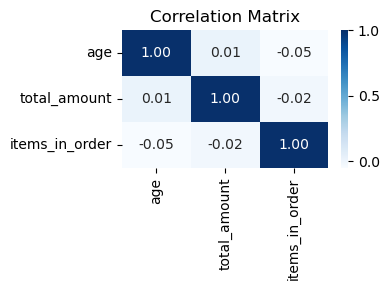

In [48]:
# Correlation analysis: age, total_amount, number of items per order
import seaborn as sns
import matplotlib.pyplot as plt

order_items_sum = df.groupby("order_id")["quantity"].sum().reset_index(name="items_in_order")
agg = o.merge(order_items_sum, on="order_id", how="left").merge(u[["user_id", "age"]], on="user_id", how="left")
cols = ["age", "total_amount", "items_in_order"]
cor_mat = agg[cols].corr()
print(cor_mat)

plt.figure(figsize=(4,3))
sns.heatmap(cor_mat, annot=True, cmap="Blues", fmt=".2f")
plt.title("Correlation Matrix")
plt.tight_layout()
plt.show()

## STEP 19: Product Brand Analysis

**Task:** Analyze product brands:
1. Count products per brand
2. Calculate total revenue by brand
3. Find top 5 brands by revenue
4. Analyze which brands are preferred by which gender
5. Create visualizations showing brand performance

In [47]:
# Product brand analysis
query_brand_count = """
SELECT brand, COUNT(*) AS product_count
FROM p
GROUP BY brand
ORDER BY product_count DESC
"""
query_brand_revenue = """
SELECT p.brand, SUM(df.quantity * p.price) AS revenue
FROM df
JOIN p ON df.product_id = p.product_id
GROUP BY p.brand
ORDER BY revenue DESC
"""
query_brand_gender = """
SELECT u.gender, p.brand, SUM(df.quantity * p.price) AS revenue
FROM df
JOIN o ON df.order_id = o.order_id
JOIN u ON o.user_id = u.user_id
JOIN p ON df.product_id = p.product_id
GROUP BY u.gender, p.brand
ORDER BY revenue DESC
"""
brand_count = sqld.sqldf(query_brand_count, globals())
brand_revenue = sqld.sqldf(query_brand_revenue, globals())
brand_gender = sqld.sqldf(query_brand_gender, globals())
print("Products per brand:\n", brand_count)
print("\nRevenue by brand:\n", brand_revenue)
print("\nRevenue by brand and gender:\n", brand_gender)


Products per brand:
              brand  product_count
0     French Style             55
1    Mediterranean             53
2     Garden Fresh             53
3      Fresh Farms             53
4       Prime Cuts             52
5         Tea Time             51
6      Ocean Fresh             51
7        Cheese Co             50
8     Nature Sweet             49
9    Healthy Start             48
10    Citrus Grove             45
11  Morning Crunch             44
12  Organic Valley             43
13      Dairy Best             42
14    Golden Grain             41
15   Nutty Delight             40
16      Java House             40
17    Italian Best             40
18      Berry Best             40
19   Asian Delight             39
20    Artisan Bake             36
21      Farm Fresh             34
22   Creamy Treats              1

Revenue by brand:
              brand   revenue
0       Prime Cuts  14366.10
1      Ocean Fresh  10465.79
2    Mediterranean   4144.95
3    Nutty Delight   4084.5

## STEP 18: Average Basket Size Analysis

**Task:** Analyze order basket sizes:
1. Count number of items per order (from order_items)
2. Calculate average number of items per order
3. Find orders with largest basket sizes
4. Compare average basket size between male and female customers
5. Create a histogram showing distribution of basket sizes

   order_id  items_in_order
0         1               8
1         2               6
2         3              14
3         4               8
4         5              12
Average items per order: 10.742

Average basket size by gender:
    gender  avg_items
0  Female  10.683367
1    Male  10.800399


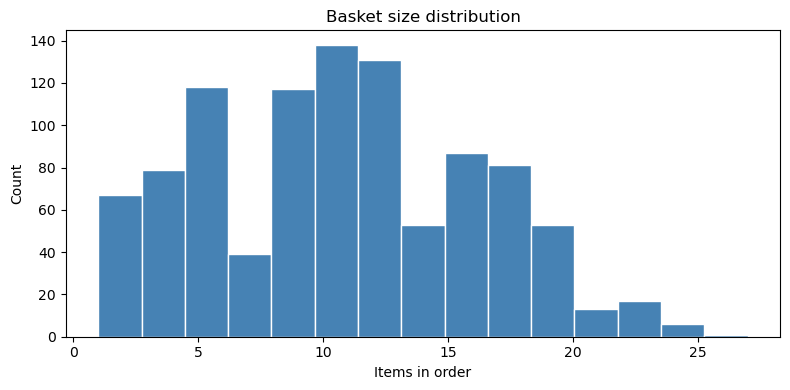

In [45]:
# Average basket size
items_per_order = df.groupby("order_id")["quantity"].sum().reset_index(name="items_in_order")
print(items_per_order.head())

avg_items = items_per_order["items_in_order"].mean()
print("Average items per order:", avg_items)

query_gender_compare = """
SELECT u.gender, AVG(x.items_in_order) AS avg_items
FROM (
  SELECT order_id, SUM(quantity) AS items_in_order
  FROM df
  GROUP BY order_id
) x
JOIN o ON x.order_id = o.order_id
JOIN u ON o.user_id = u.user_id
GROUP BY u.gender
"""
gender_avg = sqld.sqldf(query_gender_compare, globals())
print("\nAverage basket size by gender:\n", gender_avg)

import matplotlib.pyplot as plt
plt.figure(figsize=(8,4))
plt.hist(items_per_order["items_in_order"], bins=15, color="steelblue", edgecolor="white")
plt.xlabel("Items in order")
plt.ylabel("Count")
plt.title("Basket size distribution")
plt.tight_layout()
plt.show()

## STEP 17: Customer Loyalty Analysis

**Task:** Identify repeat customers:
1. Count how many orders each user has made
2. Identify users with multiple orders (repeat customers)
3. Calculate what percentage of users are repeat customers
4. Find top 10 customers by total spending
5. Find top 10 customers by number of orders

In [ ]:
# Customer loyalty analysis
query_orders_per_user = """
SELECT user_id, COUNT(*) AS order_count
FROM o
GROUP BY user_id
"""
orders_per_user = sqld.sqldf(query_orders_per_user, globals())
print("Orders per user:\n", orders_per_user.head())

query_repeat_ratio = """
SELECT 
  SUM(CASE WHEN order_count > 1 THEN 1 ELSE 0 END)*1.0 / COUNT(*) AS repeat_ratio
FROM (
  SELECT user_id, COUNT(*) AS order_count
  FROM o
  GROUP BY user_id
)
"""
repeat_ratio = sqld.sqldf(query_repeat_ratio, globals())
print("\nRepeat customer ratio:")
print(repeat_ratio)

query_top_spend = """
SELECT u.user_id, u.gender, u.age, SUM(o.total_amount) AS total_spend, COUNT(*) AS orders
FROM o
JOIN u ON o.user_id = u.user_id
GROUP BY u.user_id, u.gender, u.age
ORDER BY total_spend DESC
LIMIT 10
"""
query_top_orders = """
SELECT u.user_id, u.gender, u.age, COUNT(*) AS orders, SUM(o.total_amount) AS total_spend
FROM o
JOIN u ON o.user_id = u.user_id
GROUP BY u.user_id, u.gender, u.age
ORDER BY orders DESC
LIMIT 10
"""
top_spend = sqld.sqldf(query_top_spend, globals())
top_orders = sqld.sqldf(query_top_orders, globals())
print("\nTop 10 by total spend:\n", top_spend)
print("\nTop 10 by order count:\n", top_orders)


Orders per user:
    user_id  order_count
0        1            2
1        2            4
2        3            2
3        4            2
4        5            2

Repeat customer ratio:
   repeat_ratio
0      0.414557

Top 10 by total spend:
    user_id  gender  age  total_spend  orders
0      413    Male   52       760.43       5
1       94    Male   66       678.65       4
2      389    Male   28       638.46       4
3      916  Female   31       583.00       4
4      833    Male   44       580.86       4
5      255  Female   40       556.58       3
6      158    Male   46       533.40       3
7       87  Female   26       522.59       4
8      816  Female   39       517.21       4
9       14    Male   44       497.17       4

Top 10 by order count:
    user_id  gender  age  orders  total_spend
0       17  Female   33       5       395.98
1      317    Male   69       5       472.75
2      413    Male   52       5       760.43
3      591    Male   43       5       482.37
4        2  

## STEP 16: Customer Segmentation by Age

**Task:** Segment customers by age groups:
1. Create age bins (18-25, 26-35, 36-45, 46-55, 56+)
2. Categorize users into these age groups
3. Calculate total spending by age group
4. Calculate average order value by age group
5. Count orders by age group
6. Create visualizations showing purchasing behavior by age group

In [42]:
# Customer segmentation by age
bins = [18, 25, 35, 45, 55, 200]
labels = ["18-25", "26-35", "36-45", "46-55", "56+"]
u["age_group"] = pd.cut(u["age"], bins=bins, labels=labels, right=True)

query = """
SELECT
  age_group,
  COUNT(DISTINCT u.user_id) AS users,
  COUNT(o.order_id) AS orders,
  SUM(o.total_amount) AS total_spend,
  AVG(o.total_amount) AS avg_order_value
FROM u
LEFT JOIN o ON u.user_id = o.user_id
GROUP BY age_group
ORDER BY total_spend DESC
"""
result = sqld.sqldf(query, globals())
print(result)


  age_group  users  orders  total_spend  avg_order_value
0       56+    295     277     30409.02       109.779856
1     36-45    201     206     22567.17       109.549369
2     26-35    184     207     21281.88       102.811014
3     46-55    179     181     20128.56       111.207514
4     18-25    129     114     12906.59       113.215702
5      None     12      15      1750.40       116.693333


## STEP 15: Payment Method Analysis

**Task:** Analyze payment method preferences:
1. Count orders by payment method
2. Calculate total revenue by payment method
3. Analyze payment method preferences by gender
4. Create visualizations showing payment method distribution

In [ ]:

query_pm = """
SELECT 
    payment_method,
    COUNT(*) AS order_count,
    SUM(total_amount) AS total_revenue
FROM o
GROUP BY payment_method
ORDER BY total_revenue DESC
"""
query_pm_gender = """
SELECT 
    o.payment_method,
    u.gender,
    COUNT(*) AS order_count,
    SUM(o.total_amount) AS total_revenue
FROM o
JOIN u ON o.user_id = u.user_id
GROUP BY o.payment_method, u.gender
ORDER BY total_revenue DESC
"""
pm = sqld.sqldf(query_pm, globals())
pmg = sqld.sqldf(query_pm_gender, globals())
print(pm)
print("\nBy gender:\n", pmg)


  payment_method  order_count  total_revenue
0    Credit Card          269       28891.87
1         PayPal          242       27232.54
2           Cash          242       27020.79
3     Debit Card          247       25898.42

By gender:
   payment_method  gender  order_count  total_revenue
0    Credit Card  Female          144       14988.31
1           Cash    Male          126       14377.17
2         PayPal    Male          122       14162.49
3    Credit Card    Male          125       13903.56
4     Debit Card    Male          128       13321.62
5         PayPal  Female          120       13070.05
6           Cash  Female          116       12643.62
7     Debit Card  Female          119       12576.80


## STEP 14: Time-Based Analysis

**Task:** Analyze orders over time:
1. Convert order_date column to datetime format
2. Extract month and day from order_date
3. Count orders per month
4. Calculate revenue per month
5. Create a line chart showing orders trend over time
6. Create a line chart showing revenue trend over time

  year_month  order_count   revenue
0    2025-01          252  25679.79
1    2025-02          247  26330.62
2    2025-03          261  29788.72
3    2025-04          231  25859.01
4    2025-05            9   1385.48


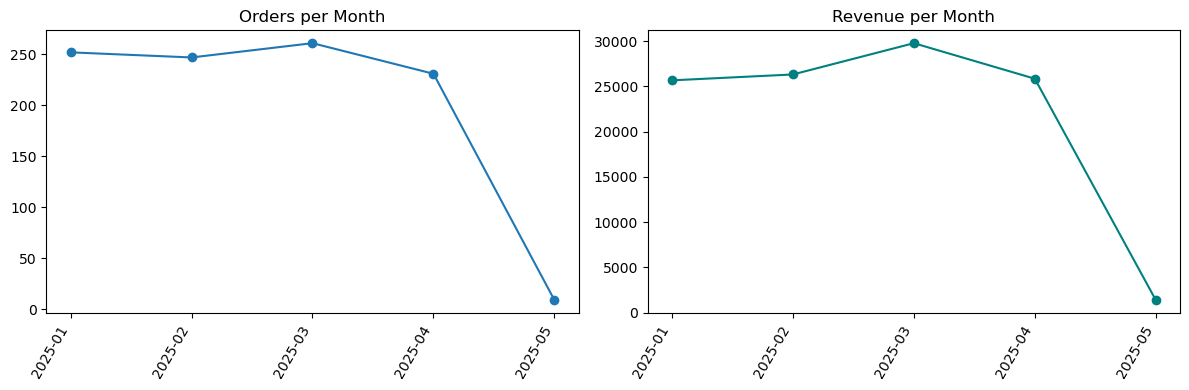

In [40]:
# Time-based analysis: convert dates, summarize by month
import pandas as pd
import matplotlib.pyplot as plt

# Ensure datetime
o["order_date"] = pd.to_datetime(o["order_date"])
o["year_month"] = o["order_date"].dt.to_period("M").astype(str)

# Orders and revenue per month
monthly = o.groupby("year_month").agg(order_count=("order_id", "count"), revenue=("total_amount", "sum")).reset_index()
print(monthly)

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(monthly["year_month"], monthly["order_count"], marker="o")
plt.xticks(rotation=60, ha="right")
plt.title("Orders per Month")
plt.subplot(1, 2, 2)
plt.plot(monthly["year_month"], monthly["revenue"], color="teal", marker="o")
plt.xticks(rotation=60, ha="right")
plt.title("Revenue per Month")
plt.tight_layout()
plt.show()

## STEP 13: Product Preferences by Gender

**Task:** Find which products are preferred by each gender:
1. Join users → orders → order_items → products
2. Group by gender and product category
3. Calculate purchase count by gender for each category
4. Create a grouped bar chart comparing male vs female preferences by category

In [39]:
# Product preferences by gender and category
query = """
SELECT u.gender, p.category, COUNT(*) AS purchase_count
FROM df
JOIN o ON df.order_id = o.order_id
JOIN u ON o.user_id = u.user_id
JOIN p ON df.product_id = p.product_id
GROUP BY u.gender, p.category
ORDER BY purchase_count DESC
"""
result = sqld.sqldf(query, globals())
print(result)


    gender           category  purchase_count
0   Female              Dairy             252
1     Male             Bakery             233
2   Female             Bakery             225
3     Male               Meat             217
4     Male         Vegetables             217
5     Male              Dairy             215
6   Female         Vegetables             214
7     Male             Fruits             214
8   Female             Fruits             187
9   Female               Meat             179
10    Male             Pantry             150
11  Female            Seafood             144
12  Female             Pantry             140
13  Female          Beverages             138
14    Male            Seafood             138
15  Female  Dairy Alternative             124
16    Male          Beverages             114
17    Male  Dairy Alternative             105
18  Female          Breakfast              83
19  Female         Condiments              81
20    Male          Breakfast     

## STEP 12: Top Selling Products

**Task:** Find the most popular products:
1. Join order_items → products
2. Calculate total quantity sold per product
3. Calculate total revenue per product
4. Find top 10 products by quantity sold
5. Find top 10 products by revenue
6. Create visualizations for both rankings

Total quantity per product (top 10):
   product_id     product_name  total_quantity_sold
0           5    Roma Tomatoes                  160
1           7     Orange Juice                  151
2           1  Organic Bananas                  148
3          29   Sweet Potatoes                  146
4          60       Sour Cream                  141
5          23       Croissants                  140
6          30         Soy Milk                  140
7          54    Navel Oranges                  140
8          33         Avocados                  138
9           4   Chicken Breast                  133

Total revenue per product (top 10):
   product_id   product_name  total_revenue
0          70    Beef Ribeye        2183.85
1          24     Lamb Chops        1936.86
2          69     Lamb Chops        1774.89
3          12  Salmon Fillet        1693.87
4          93      Olive Oil        1597.77
5          36     Beef Steak        1455.09
6          79     Cod Fillet        1378.85
7 

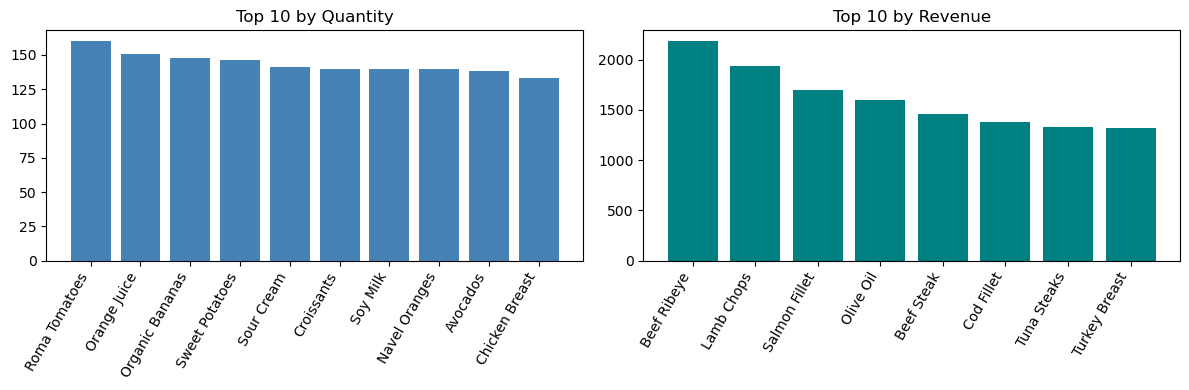

In [38]:
# Top selling products: quantity and revenue, plus top 10 by each
query_qty = """
SELECT 
    p.product_id,
    p.product_name,
    SUM(df.quantity) AS total_quantity_sold
FROM df
JOIN p ON df.product_id = p.product_id
GROUP BY p.product_id, p.product_name
ORDER BY total_quantity_sold DESC
"""
query_rev = """
SELECT 
    p.product_id,
    p.product_name,
    SUM(df.quantity * p.price) AS total_revenue
FROM df
JOIN p ON df.product_id = p.product_id
GROUP BY p.product_id, p.product_name
ORDER BY total_revenue DESC
"""
qty_result = sqld.sqldf(query_qty, globals())
rev_result = sqld.sqldf(query_rev, globals())
print("Total quantity per product (top 10):")
print(qty_result.head(10))
print("\nTotal revenue per product (top 10):")
print(rev_result.head(10))

# Simple bar charts for top 10 by quantity and revenue
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.bar(qty_result.head(10)["product_name"], qty_result.head(10)["total_quantity_sold"], color="steelblue")
plt.xticks(rotation=60, ha="right")
plt.title("Top 10 by Quantity")
plt.subplot(1, 2, 2)
plt.bar(rev_result.head(10)["product_name"], rev_result.head(10)["total_revenue"], color="teal")
plt.xticks(rotation=60, ha="right")
plt.title("Top 10 by Revenue")
plt.tight_layout()
plt.show()

## STEP 11: Find Females Who Ordered Specific Products

**Task:** Answer: "How many females ordered Organic Bananas (product_id=1)?"
1. Join users → orders → order_items → products
2. Filter where gender = 'Female' AND product_id = 1
3. Count unique female users who ordered this product
4. Repeat for 2-3 other products of your choice

In [37]:
query = """
SELECT COUNT(DISTINCT u.user_id) AS user_count
FROM u
JOIN o ON u.user_id = o.user_id
JOIN df ON o.order_id = df.order_id
JOIN p ON p.product_id = df.product_id
WHERE u.gender = 'Female'
  AND p.product_id = 1
"""
result = sqld.sqldf(query, globals())
print(result)

   user_count
0          16


## STEP 10: Gender-Based Purchasing Analysis

**Task:** Analyze purchasing patterns by gender:
1. Join users → orders to link orders to gender
2. Calculate total spending by gender
3. Calculate average order value by gender
4. Count total orders by gender
5. Create visualizations comparing male vs female purchasing behavior

In [36]:
query = """
SELECT u.gender, sum(o.total_amount) AS total_amount
FROM o
JOIN u ON o.user_id = u.user_id
GROUP BY u.gender
"""
result = sqld.sqldf(query, globals())
print(result)


   gender  total_amount
0  Female      53278.78
1    Male      55764.84


In [32]:
query = """
SELECT u.gender, avg(o.total_amount) AS avg_amount
FROM o
JOIN u ON o.user_id = u.user_id
GROUP BY u.gender
"""
result = sqld.sqldf(query, globals())
print(result)


   gender  avg_amount
0  Female  106.771102
1    Male  111.307066


In [30]:
query = """
SELECT u.gender, count(*) AS totalordercount
FROM o
JOIN u ON o.user_id = u.user_id
GROUP BY u.gender
"""
result = sqld.sqldf(query, globals())
print(result)


   gender  totalordercount
0  Female              499
1    Male              501


## STEP 9: Regional Analysis

**Task:** Analyze sales by region:
1. Join stores → locations to get region information
2. Then join with orders to link orders to regions
3. Calculate total revenue by region
4. Count orders by region
5. Create a bar chart showing revenue by region

In [29]:
# Join stores → locations → orders and calculate revenue by region
query = """
SELECT 
    l.region,
    SUM(o.total_amount) as total_revenue
FROM o
JOIN s ON o.store_id = s.store_id
JOIN l ON s.location_id = l.location_id
GROUP BY l.region
ORDER BY total_revenue DESC
"""
result = sqld.sqldf(query, globals())
print(result)

      region  total_revenue
0      South       25070.57
1  Northeast       23179.82
2       West       22214.15
3  Southwest       18708.06
4    Midwest       15289.39
5  Southeast        4581.63


Order Count by Region:
      region  order_count
0      South          229
1       West          210
2  Northeast          207
3  Southwest          169
4    Midwest          145
5  Southeast           40

Total Revenue by Region:
      region  total_revenue
0      South       25070.57
1  Northeast       23179.82
2       West       22214.15
3  Southwest       18708.06
4    Midwest       15289.39
5  Southeast        4581.63


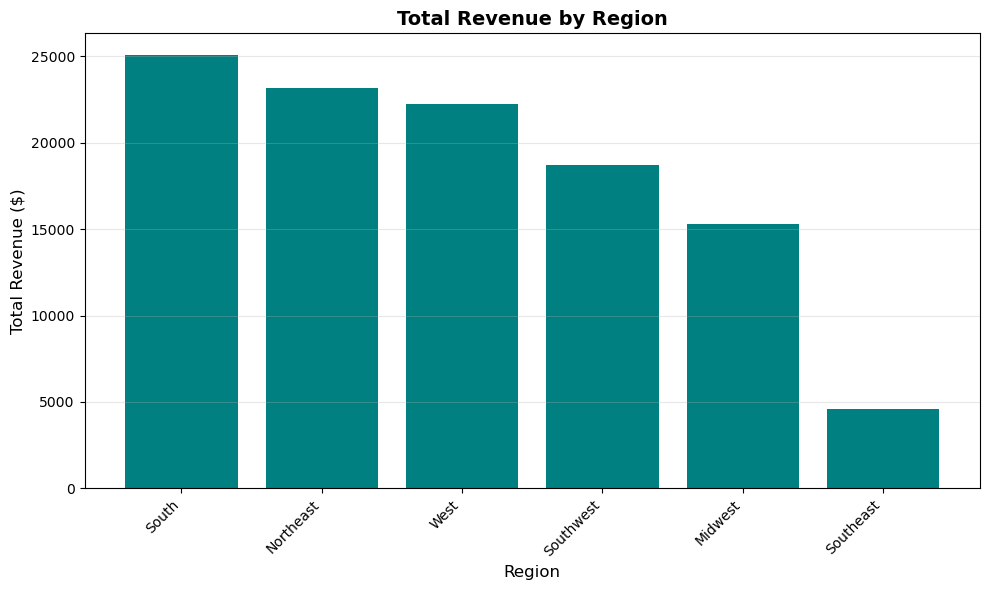

In [28]:
# Count orders by region
query = """
SELECT 
    l.region,
    COUNT(o.order_id) as order_count
FROM o
JOIN s ON o.store_id = s.store_id
JOIN l ON s.location_id = l.location_id
GROUP BY l.region
ORDER BY order_count DESC
"""
result2 = sqld.sqldf(query, globals())
print("Order Count by Region:")
print(result2)

# Calculate total revenue by region
query = """
SELECT 
    l.region,
    SUM(o.total_amount) as total_revenue
FROM o
JOIN s ON o.store_id = s.store_id
JOIN l ON s.location_id = l.location_id
GROUP BY l.region
ORDER BY total_revenue DESC
"""
result1 = sqld.sqldf(query, globals())
print("\nTotal Revenue by Region:")
print(result1)

# Create bar chart showing revenue by region
plt.figure(figsize=(10, 6))
plt.bar(result1['region'], result1['total_revenue'], color='teal')
plt.xlabel('Region', fontsize=12)
plt.ylabel('Total Revenue ($)', fontsize=12)
plt.title('Total Revenue by Region', fontsize=14, fontweight='bold')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

## STEP 9B: Location Performance Analysis

**Task:** Analyze performance by city/location:
1. Calculate total orders per location (city)
2. Calculate total revenue per location
3. Find the location with most orders
4. Find the location with least orders
5. Find the location with highest revenue
6. Create visualizations comparing locations

Location Performance (sorted by revenue):
    location_id          city state     region  order_count  total_revenue  \
0             2      New York    NY  Northeast           47        4998.67   
1            31   Albuquerque    NM  Southwest           41        4996.53   
2             1      New York    NY  Northeast           42        4887.46   
3            13        Austin    TX      South           38        4500.24   
4             7       Phoenix    AZ  Southwest           46        4422.42   
5             4   Los Angeles    CA       West           39        4344.92   
6             5       Chicago    IL    Midwest           41        4245.52   
7             8  Philadelphia    PA  Northeast           38        4082.92   
8            32        Tucson    AZ  Southwest           31        3963.62   
9             9   San Antonio    TX      South           33        3846.13   
10            3      New York    NY  Northeast           36        3780.67   
11           10     Sa

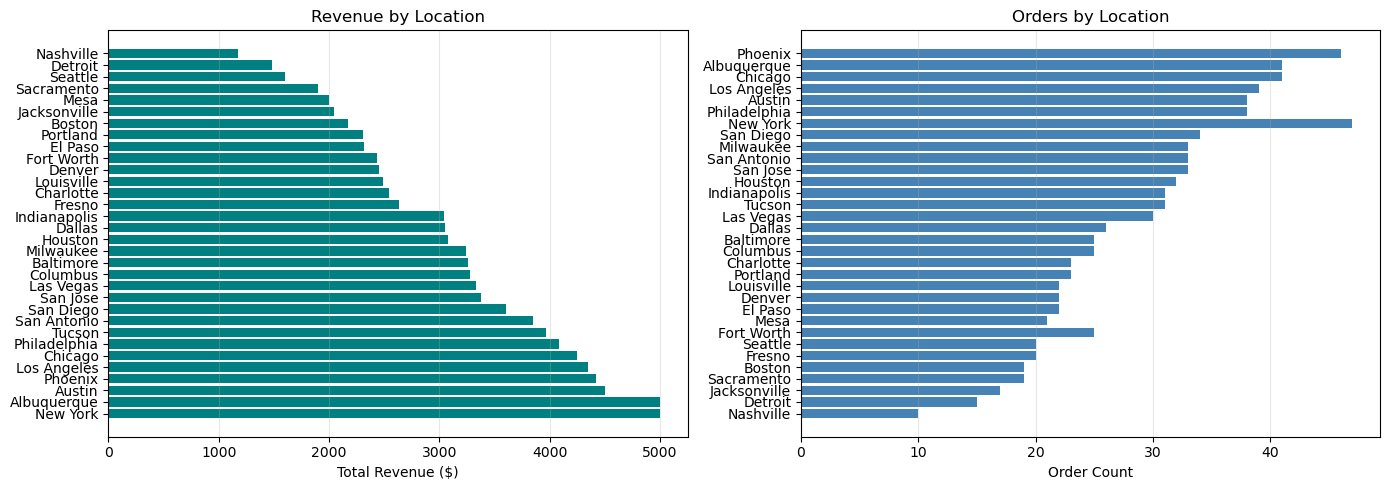

In [22]:
# Location performance analysis: orders and revenue per city
query = """
SELECT 
    l.location_id,
    l.city,
    l.state,
    l.region,
    COUNT(o.order_id) AS order_count,
    SUM(o.total_amount) AS total_revenue,
    AVG(o.total_amount) AS avg_order_value
FROM o
JOIN s ON o.store_id = s.store_id
JOIN l ON s.location_id = l.location_id
GROUP BY l.location_id, l.city, l.state, l.region
ORDER BY total_revenue DESC
"""
location_perf = sqld.sqldf(query, globals())
print("Location Performance (sorted by revenue):")
print(location_perf)

print("\n" + "="*60)
print(f"Highest Revenue Location: {location_perf.iloc[0]['city']}, {location_perf.iloc[0]['state']} - ${location_perf.iloc[0]['total_revenue']:.2f}")
print(f"Lowest Revenue Location: {location_perf.iloc[-1]['city']}, {location_perf.iloc[-1]['state']} - ${location_perf.iloc[-1]['total_revenue']:.2f}")

# Sort by orders to find most/least orders
location_orders = location_perf.sort_values("order_count", ascending=False)
print(f"\nMost Orders Location: {location_orders.iloc[0]['city']}, {location_orders.iloc[0]['state']} - {location_orders.iloc[0]['order_count']} orders")
print(f"Least Orders Location: {location_orders.iloc[-1]['city']}, {location_orders.iloc[-1]['state']} - {location_orders.iloc[-1]['order_count']} orders")

# Visualization: bar charts for revenue and orders by location
import matplotlib.pyplot as plt
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Revenue by location
ax1.barh(location_perf['city'], location_perf['total_revenue'], color='teal')
ax1.set_xlabel('Total Revenue ($)')
ax1.set_title('Revenue by Location')
ax1.grid(axis='x', alpha=0.3)

# Orders by location
location_orders_sorted = location_perf.sort_values('order_count', ascending=True)
ax2.barh(location_orders_sorted['city'], location_orders_sorted['order_count'], color='steelblue')
ax2.set_xlabel('Order Count')
ax2.set_title('Orders by Location')
ax2.grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.show()

## STEP 8: Store Performance Analysis

**Task:** Analyze store performance:
1. Join orders with stores to get store names
2. Calculate total revenue per store
3. Count number of orders per store
4. Calculate average order value per store
5. Create a bar chart showing top 5 stores by revenue

In [21]:
query="select sum(total_amount) as revenue, store_id from s join o using (store_id) group by store_id"
result=sqld.sqldf(query,globals())
print(result)

    revenue  store_id
0   2044.64         1
1   2106.75         2
2   2689.03         3
3   1520.08         4
4   1786.47         5
..      ...       ...
90  1444.64        91
91  1132.66        92
92   763.79        93
93  1126.98        94
94   867.57        95

[95 rows x 2 columns]


In [20]:
query="select count(order_id) as totalordercount,store_id from s join o using (store_id) group by store_id"
result=sqld.sqldf(query,globals())
print(result)

    totalordercount  store_id
0                21         1
1                21         2
2                24         3
3                17         4
4                17         5
..              ...       ...
90               12        91
91               11        92
92                8        93
93               12        94
94                9        95

[95 rows x 2 columns]


In [19]:
query=" select avg(total_amount) as avgtotal,store_id from s join o using (store_id) group by store_id"
result=sqld.sqldf(query,globals())
print(result)

      avgtotal  store_id
0    97.363810         1
1   100.321429         2
2   112.042917         3
3    89.416471         4
4   105.086471         5
..         ...       ...
90  120.386667        91
91  102.969091        92
92   95.473750        93
93   93.915000        94
94   96.396667        95

[95 rows x 2 columns]


            store_name  total_revenue
0   FreshMart Westside        2689.03
1       ValueMart East        2119.39
2    GreenGrocer North        2106.75
3  GreenGrocer Central        2092.23
4   FreshMart Downtown        2044.64


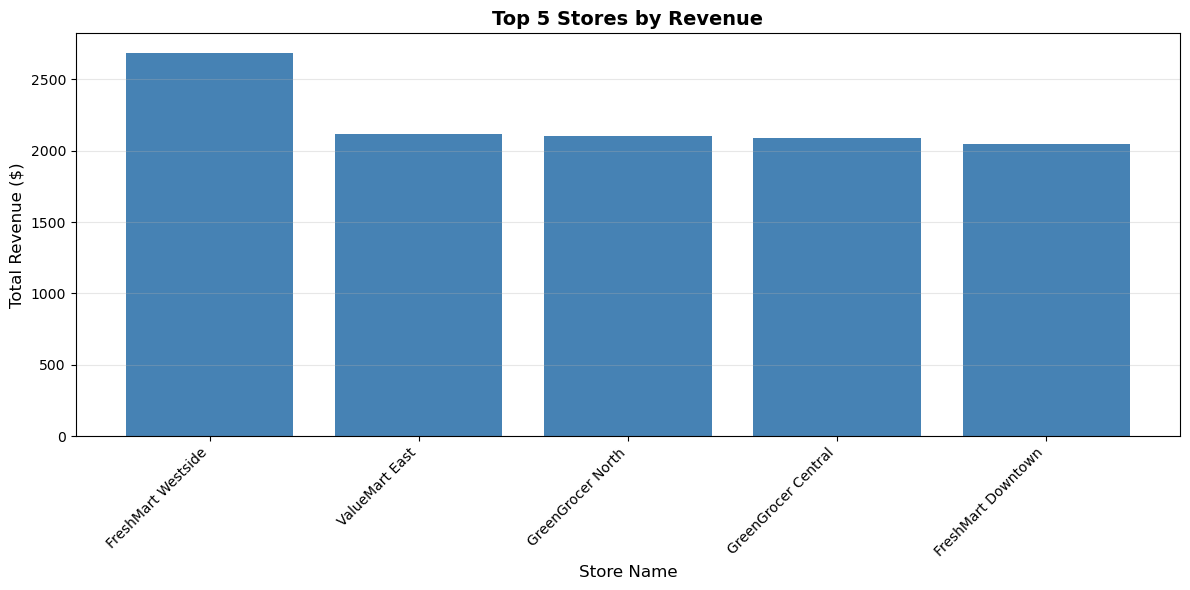

In [18]:
# Get top 5 stores by revenue with store names
query = """
SELECT 
    s.store_name,
    SUM(o.total_amount) as total_revenue
FROM s 
JOIN o USING (store_id)
GROUP BY s.store_id, s.store_name
ORDER BY total_revenue DESC
LIMIT 5
"""
result = sqld.sqldf(query, globals())
print(result)   

# Create bar chart for top 5 stores
plt.figure(figsize=(12, 6))
plt.bar(result['store_name'], result['total_revenue'], color='steelblue')
plt.xlabel('Store Name', fontsize=12)
plt.ylabel('Total Revenue ($)', fontsize=12)
plt.title('Top 5 Stores by Revenue', fontsize=14, fontweight='bold')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

## STEP 7: Order Status Analysis

**Task:** Analyze order statuses:
1. Count orders by status (Delivered, In Transit, Processing, Pending)
2. Calculate total revenue by status
3. Create a visualization showing order distribution by status

In [17]:
query="select status,count(order_id) from o group by status"
result=sqld.sqldf(query,globals())
print(result)

       status  count(order_id)
0   Delivered              296
1  In Transit              242
2     Pending              234
3  Processing              228


In [16]:
query="select status,total_amount from o group by status"
result=sqld.sqldf(query,globals())
print(result)


       status  total_amount
0   Delivered         45.67
1  In Transit         64.45
2     Pending         87.67
3  Processing         76.23


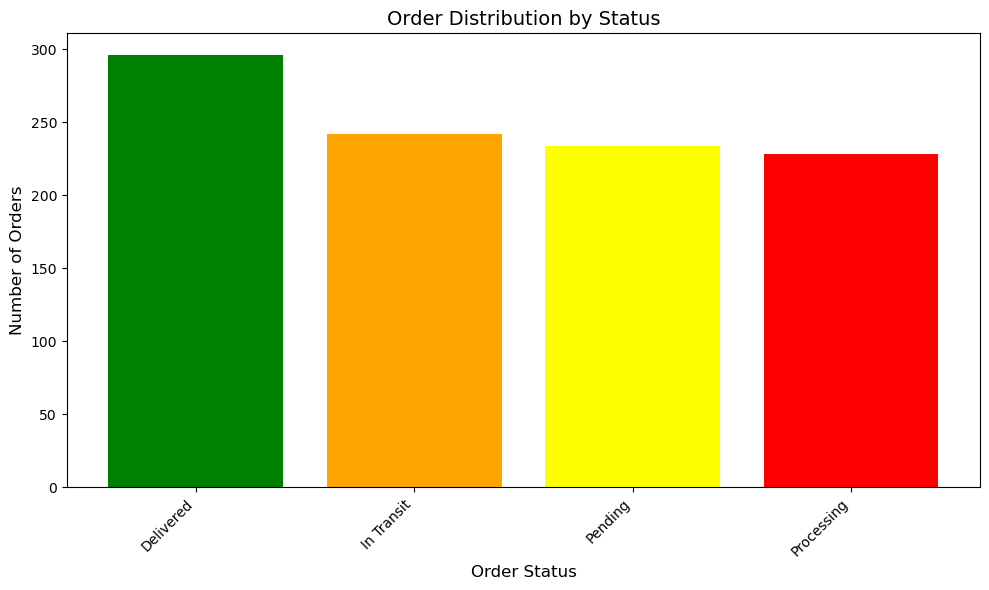

In [15]:
# Get order counts by status
status_count = o['status'].value_counts()

# Create bar chart
plt.figure(figsize=(10, 6))
plt.bar(status_count.index, status_count.values, color=['green', 'orange', 'yellow', 'red'])
plt.xlabel('Order Status', fontsize=12)
plt.ylabel('Number of Orders', fontsize=12)
plt.title('Order Distribution by Status', fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show() 

## STEP 6: Product Category Analysis

**Task:** Analyze product categories:
1. Count products per category using `.value_counts()`
2. Calculate average price per category using `.groupby()` and `.mean()`
3. Find the most expensive product in each category
4. Create a bar chart showing product count by category

In [14]:
query="select product_name,count(product_id),category from p group  by category"
result=sqld.sqldf(query,globals())
print(result)

                   product_name  count(product_id)           category
0             Whole Wheat Bread                 79             Bakery
1                  Orange Juice                 77          Beverages
2                        Cereal                 64          Breakfast
3   Classic Mozzarella Shredded                 67       Canned Goods
4                         Honey                 65         Condiments
5                    Whole Milk                 72              Dairy
6                   Almond Milk                  6  Dairy Alternative
7         Organic Cheese Slices                 68               Deli
8                     Ice Cream                 70             Frozen
9               Organic Bananas                 56             Fruits
10               Chicken Breast                 80               Meat
11                        Pasta                 78             Pantry
12                Salmon Fillet                 76            Seafood
13                  

In [13]:
query="select category,avg(price) from p group by category order by price"
result=sqld.sqldf(query,globals())
print(result)

             category  avg(price)
0              Fruits    9.924464
1              Pantry   11.469872
2          Vegetables    8.190563
3              Bakery    9.650633
4               Dairy   10.245278
5   Dairy Alternative    4.990000
6           Beverages   11.270000
7           Breakfast   12.173125
8              Frozen   10.672571
9          Condiments   10.212154
10               Meat   11.577625
11       Canned Goods   11.387612
12               Deli   10.871912
13             Snacks   11.943662
14            Seafood   11.477237


In [12]:
query="select product_name, max(price),category from p group by category" 
result=sqld.sqldf(query,globals())
print(result)

                   product_name  max(price)           category
0              Organic Broccoli       19.52             Bakery
1                Blueberry Pack       19.91          Beverages
2            Extra Bell Peppers       19.85          Breakfast
3                   Canned Tuna       19.78       Canned Goods
4                   Grape Juice       19.95         Condiments
5   Organic Ice Cream Chocolate       19.61              Dairy
6                      Oat Milk        5.49  Dairy Alternative
7                   Tuna Steaks       19.75               Deli
8                   Tuna Steaks       19.85             Frozen
9                 Almond Butter       19.76             Fruits
10           Cereal Corn Flakes       19.96               Meat
11          Fresh Ground Turkey       19.90             Pantry
12    Organic Cookies Chocolate       19.93            Seafood
13                     Soy Milk       19.86             Snacks
14                   Rice White       19.24         Veg

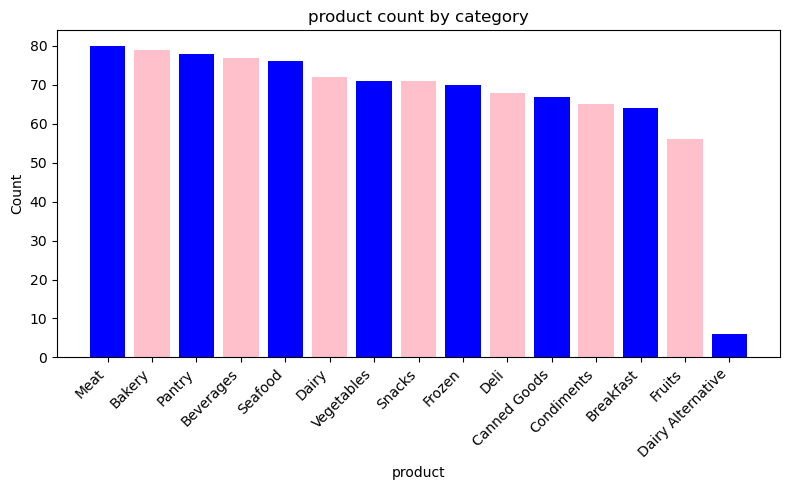

In [11]:
product_count = p['category'].value_counts()
plt.figure(figsize=(8, 5))
plt.bar(product_count.index, product_count.values, color=['blue', 'pink'])
plt.xlabel('product')
plt.ylabel('Count')
plt.title('product count by category')
plt.xticks(rotation=45, ha='right')  # Rotate labels if category names are long
plt.tight_layout() 
plt.show()


## STEP 5: User Analysis by Gender

**Task:** Analyze the user distribution:
1. Count how many Male vs Female users using `.value_counts()` on gender column
2. Calculate percentage distribution
3. Create a bar chart or pie chart showing gender distribution

In [9]:
import pandasql as sqld
query= "select gender,count(user_id) FROM u where gender='Male'"
result=sqld.sqldf(query,globals())
print(result) 

query1="select gender,count(user_id) FROM u where gender='Female'"
result1=sqld.sqldf(query1,globals())
print(result1)


  gender  count(user_id)
0   Male             479
   gender  count(user_id)
0  Female             521


In [10]:
query1 = "SELECT gender, COUNT(*) as COUNT, (COUNT(*)*100.0/(SELECT COUNT(*) FROM u)) as PERCENTAGE FROM u GROUP BY gender"
result2 = sqld.sqldf(query1, globals())
print(result2)

   gender  COUNT  PERCENTAGE
0  Female    521        52.1
1    Male    479        47.9


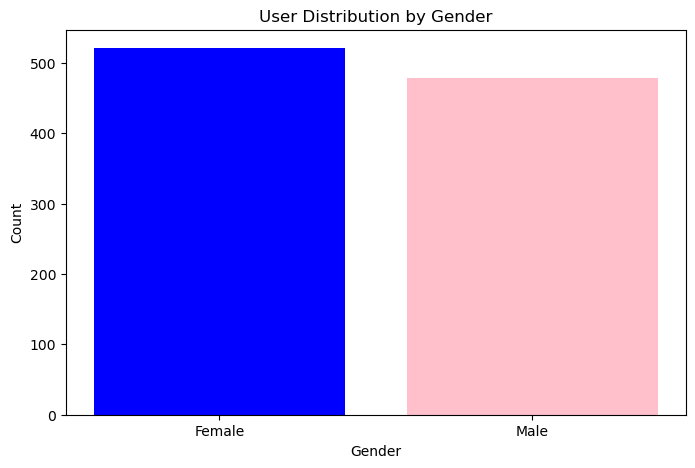

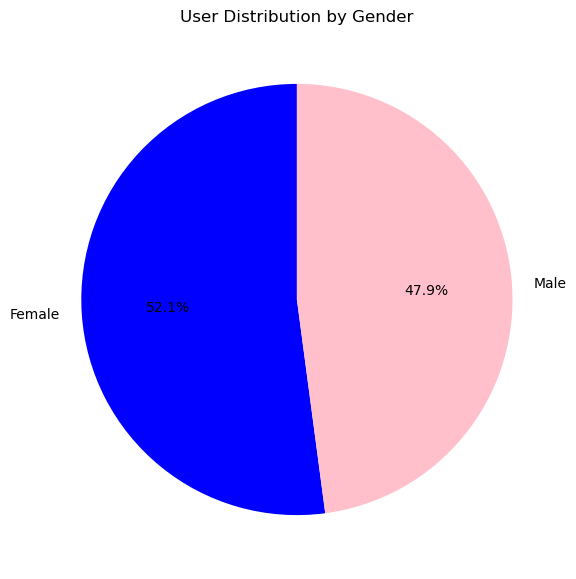

In [7]:
# Bar Chart
import matplotlib.pyplot as plt

gender_count = u['gender'].value_counts()
plt.figure(figsize=(8, 5))
plt.bar(gender_count.index, gender_count.values, color=['blue', 'pink'])
plt.xlabel('Gender')
plt.ylabel('Count')
plt.title('User Distribution by Gender')
plt.show()

# Pie Chart
plt.figure(figsize=(7, 7))
plt.pie(gender_count.values, labels=gender_count.index, autopct='%1.1f%%', 
        colors=['blue', 'pink'], startangle=90)
plt.title('User Distribution by Gender')
plt.show()

## STEP 4: Basic Descriptive Statistics

**Task:** For numeric columns, get descriptive statistics:
1. Use `.describe()` on orders DataFrame to see total_amount statistics
2. Use `.describe()` on products DataFrame to see price and stock statistics
3. Use `.describe()` on users DataFrame to see age statistics

In [6]:
df['subtotal'].describe()
o.describe()
df.describe()


,order_item_id,order_id,product_id,quantity,unit_price,subtotal
count,3555.000000,3555.000000,3555.000000,3555.000000,3555.000000,3555.000000
mean,1778.000000,491.760056,49.115049,3.021660,6.759930,20.259179
std,1026.384431,290.657726,29.362175,1.396931,3.782938,15.566833
min,1.000000,1.000000,1.000000,1.000000,1.490000,1.490000
25%,889.500000,242.000000,23.500000,2.000000,3.990000,8.990000
50%,1778.000000,486.000000,49.000000,3.000000,5.490000,15.960000
75%,2666.500000,744.500000,74.000000,4.000000,8.490000,26.970000
max,3555.000000,1000.000000,100.000000,8.000000,18.990000,94.950000


## STEP 3: Data Exploration - Check Data Structure

**Task:** For each DataFrame, display:
1. First 5 rows using `.head()`
2. Shape (rows, columns) using `.shape`
3. Column names and data types using `.info()`
4. Check for missing values using `.isnull().sum()`

In [5]:
df.head(5)
df.isnull().sum()
s.head(5)
s.isnull().sum()

store_id         0
store_name       0
location_id      0
manager_name     0
phone            0
email            0
opening_hours    0
dtype: int64

## STEP 2: Load All CSV Files

*

In [4]:
s = pd.read_csv('C:/Users/Public/grocery_dataset/stores.csv')
l= pd.read_csv('C:/Users/Public/grocery_dataset/locations.csv')
u= pd.read_csv('C:/Users/Public/grocery_dataset/users.csv')
p = pd.read_csv('C:/Users/Public/grocery_dataset/products.csv')
o = pd.read_csv('C:/Users/Public/grocery_dataset/orders.csv')
df = pd.read_csv('C:/Users/Public/grocery_dataset/order_items.csv')







In [2]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as m 
import seaborn as s 


## STEP 1: Import Required Libraries

**Task:** Import pandas, numpy, matplotlib, and seaborn libraries. Set display options for better viewing.